In [84]:
# we need to deal with those with limited pbd info
# 'GAL4_YEAST_Shendure2015-SEL_C_40h', 7uik starts with 8
import os
def filter_entry(entry,lab_func):

    dir = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/{entry}_old'
    import pandas as pd
    data = pd.read_csv(f'{dir}/data.csv')
    # drop those with int(mutant[1:-1])<8, return mask first
    mask = data['mutant'].apply(lab_func)
    data = data[mask].reset_index(drop=True)
    
    save_path = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/{entry}'
    # mkdir -p save_path
    os.makedirs(save_path, exist_ok=True)
    print(save_path)
    data.to_csv(f'{save_path}/data.csv', index=False)
    # read fasta
    fasta_file = f'{dir}/seqs.fasta'
    from Bio import SeqIO
    def read_fasta(filename, return_ids=False):
        records = SeqIO.parse(filename, 'fasta')
        seqs = list()
        ids = list()
        for record in records:
            seqs.append(str(record.seq))
            ids.append(str(record.id))
        if return_ids:
            return seqs, ids
        else:
            return seqs
    fasta = read_fasta(fasta_file)
    fasta = [fasta[i] for i in range(len(fasta)) if mask[i]]
    # save fasta and ids
    with open(f'{save_path}/seqs.fasta', 'w') as f:
        for i in range(len(fasta)):
            f.write(f'>id_{i}\n{fasta[i]}\n')
    # also save seqs to seqs.txt
    with open(f'{save_path}/seqs.txt', 'w') as f:
        for i in range(len(fasta)):
            f.write(f'{fasta[i]}\n')
# filter_entry('GAL4_YEAST_Shendure2015-SEL_C_40h',lambda x: int(x[1:-1])>=8)
filter_entry('HSP82_YEAST_Bolon2016-selection_coefficient',lambda x: int(x[1:-1])<=214 if (x != 'WT') else False)

/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/HSP82_YEAST_Bolon2016-selection_coefficient


In [85]:
import pandas as pd
label_proteingym_map = {
    'BG_STRSQ_Abate2015-enrichment':'Q59976_STRSQ_Romero_2015',
    'BLAT_ECOLX_Ranganathan2015-2500': 'BLAT_ECOLX_Stiffler_2015',
    'BLAT_ECOLX_Ostermeier2014-linear':'BLAT_ECOLX_Firnberg_2014',
    'BLAT_ECOLX_Palzkill2012-ddG_stat':'BLAT_ECOLX_Deng_2012',
    'BLAT_ECOLX_Tenaillon2013-singles-MIC_score':'BLAT_ECOLX_Jacquier_2013',
    'DLG4_RAT_Ranganathan2012-CRIPT':'DLG4_RAT_McLaughlin_2012', # pdz
    'GAL4_YEAST_Shendure2015-SEL_C_40h':'GAL4_YEAST_Kitzman_2015',
    'HSP82_YEAST_Bolon2016-selection_coefficient': 'HSP82_YEAST_Mishra_2016',
    'KKA2_KLEPN_Mikkelsen2014-Kan18_avg':'KKA2_KLEPN_Melnikov_2014',
    'RL401_YEAST_Bolon2013-selection_coefficient':'RL40A_YEAST_Roscoe_2013',
    'RL401_YEAST_Bolon2014-react_rel':'RL40A_YEAST_Roscoe_2014',
    'YAP1_HUMAN_Fields2012-singles-linear':'YAP1_HUMAN_Araya_2012'
    
    
    
}

    # 'BRCA1_HUMAN_Fields2015-e3': ?
    # 'GFP_AEQVI_Sarkisyan2016': 'GFP_AEQVI_Sarkisyan_2016'
    # 'MTH3_HAEAESTABILIZED_Tawfik2015-Wrel_G17_filtered': 'MTH3_HAEAE_RockahShmuel_2015'
    #''PABP_YEAST_Fields2013-linear':'PABP_YEAST_Melamed_2013'
    # 'POLG_HCVJF_Sun2014-fitness':'POLG_HCVJF_Qi_2014'
    # 'UBE4B_MOUSE_Klevit2013-nscor_log2_ratio':'UBE4B_MOUSE_Starita_2013'

dataset_score = {}
for label_name,proteingym_name in label_proteingym_map.items():
    proteingym_ground_truth_file = f'/work/commons/proteingym/DMS_ProteinGym_substitutions/{proteingym_name}.csv'
    
    models = ['ESM1b','EVmutation','DeepSequence','UniRep_evotuned']
    value_name = ['esm1b_t33_650M_UR50S','prediction_epistatic','evol_indices_ensemble','Unirep_score']
    value_name = dict(zip(models,value_name))
    models_dict = {}
    for model in models:
        proteingym_model_file = f'/work/commons/proteingym/zero_shot_substitutions_scores/{model}/{proteingym_name}.csv'
        proteingym_model = pd.read_csv(proteingym_model_file)
        models_dict[model] = proteingym_model

    label_file = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/{label_name}/data.csv'
    import pandas as pd
    proteingym_gt_file = pd.read_csv(proteingym_ground_truth_file)
    label = pd.read_csv(label_file)
    scores = dict(zip(models,[[] for i in range(len(models))]))
    for i, row in label.iterrows():
        
        mutant_key = 'mutant'
        # print(row[mutant_key])
        if row[mutant_key] == 'WT':
            for model in models:
                scores[model].append(0)
            continue

        if label_name in ['DLG4_RAT_Ranganathan2012-CRIPT'] and row[mutant_key] not in proteingym_gt_file[mutant_key].values:
            print(row[mutant_key])
            for model in models:
                scores[model].append(0)
            continue
        assert row[mutant_key] in proteingym_gt_file[mutant_key].values
        idx = proteingym_gt_file[proteingym_gt_file[mutant_key] == row[mutant_key]].index[0]
        # check mutated sequence
        assert row[mutant_key] in proteingym_gt_file[mutant_key][idx]
        
        for model in models:
            # print(model)
            proteingym_model = models_dict[model]
            value = value_name[model]
            if model is not 'UniRep_evotuned':
                model_score = proteingym_model[proteingym_model[mutant_key] == row[mutant_key]][value]
            else:
                model_score = proteingym_model[proteingym_model['mutated_sequence'] == proteingym_gt_file['mutated_sequence'][idx]][value]
            scores[model].append(model_score.values[0])
    dataset_score[label_name] = scores

P311A


In [95]:

key = 'YAP1_HUMAN_Fields2012-singles-linear'
model_dir = dict(zip(models,['esm','ev','DeepSequence','eUniRep']))
import os
for model in models:
    print(model)
    print(len(dataset_score[key][model]))
    pll_values = dataset_score[key][model]

    # 生成相应的id
    ids = [f'id_{i}' for i in range(len(pll_values))]

    # 创建DataFrame
    df = pd.DataFrame({'pll': pll_values}, index=ids)

    # 将结果写入CSV文件
    #mkdir -p inference/{key}/esm
    os.makedirs(f'inference/{key}/{model_dir[model]}', exist_ok=True)
    df.to_csv(f'inference/{key}/{model_dir[model]}/pll.csv', index=True)

ESM1b
319
EVmutation
319
DeepSequence
319
UniRep_evotuned
319


In [96]:

import pandas as pd
# key = 'BG_STRSQ_Abate2015-enrichment'
for key in ['BG_STRSQ_Abate2015-enrichment']:
    df_ = pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/{key}/results.csv')

    # df_ =pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/BLAT_ECOLX_Ranganathan2015-2500/results_BLAT_ECOLX_Ranganathan2015-2500.csv')
    CORE_PREDICTORS = [
        'onehot',
        'ev+onehot', 
        'gesm+onehot', 
        'eunirep_ll+onehot',
        'vae+onehot', 
        'ev+onehot+ddg', 
        'gesm+onehot+ddg', 
        'eunirep_ll+onehot+ddg',
        'vae+onehot+ddg'
    ]
    for model in CORE_PREDICTORS:
        print(model, df_[df_.predictor==model].spearman.mean())

onehot 0.6258499999999999
ev+onehot 0.6882049999999998
gesm+onehot 0.6781000000000001
eunirep_ll+onehot 0.6402549999999999
vae+onehot 0.7043699999999999
ev+onehot+ddg 0.720545
gesm+onehot+ddg 0.7010500000000001
eunirep_ll+onehot+ddg 0.69058
vae+onehot+ddg 0.7289950000000001


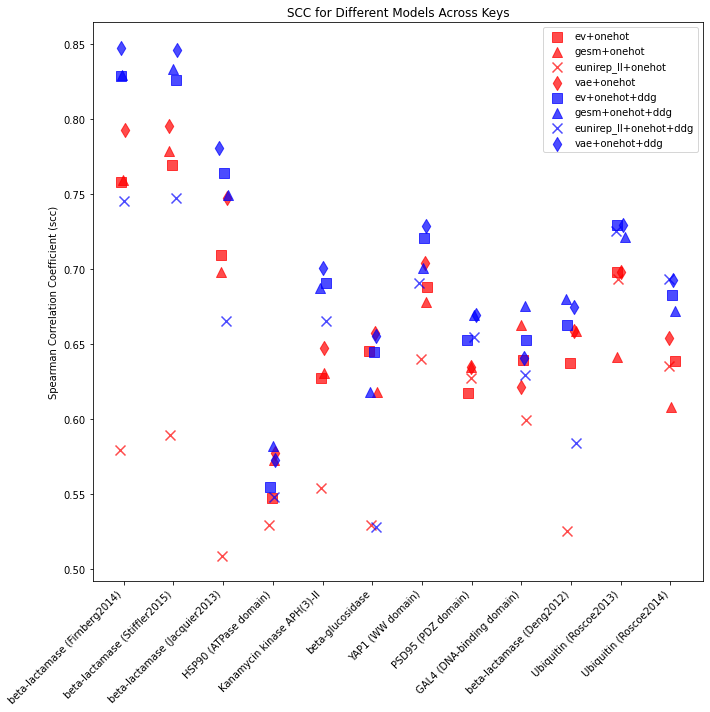

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

files = [
    'BLAT_ECOLX_Ostermeier2014-linear',
    'BLAT_ECOLX_Ranganathan2015-2500',
    'BLAT_ECOLX_Tenaillon2013-singles-MIC_score',
    'HSP82_YEAST_Bolon2016-selection_coefficient',
    'KKA2_KLEPN_Mikkelsen2014-Kan18_avg',
    'BG_STRSQ_Abate2015-enrichment',
    'YAP1_HUMAN_Fields2012-singles-linear',
    'DLG4_RAT_Ranganathan2012-CRIPT',
    'GAL4_YEAST_Shendure2015-SEL_C_40h',
    'BLAT_ECOLX_Palzkill2012-ddG_stat',
    'RL401_YEAST_Bolon2013-selection_coefficient',
    'RL401_YEAST_Bolon2014-react_rel',
    




]

# 按照图中的顺序调整后的 labels 列表
labels = [
    'beta-lactamase (Firnberg2014)',
    'beta-lactamase (Stiffler2015)',
    'beta-lactamase (Jacquier2013)',
    'HSP90 (ATPase domain)',
    'Kanamycin kinase APH(3)-II',
    'beta-glucosidase',
    'YAP1 (WW domain)',
    'PSD95 (PDZ domain)',
    'GAL4 (DNA-binding domain)',
    'beta-lactamase (Deng2012)',
    'Ubiquitin (Roscoe2013)',
    'Ubiquitin (Roscoe2014)',
    



]

# 定义模型和颜色、形状
CORE_PREDICTORS = [
    # 'onehot',
    'ev+onehot', 
    'gesm+onehot', 
    'eunirep_ll+onehot',
    'vae+onehot', 
    'ev+onehot+ddg', 
    'gesm+onehot+ddg', 
    'eunirep_ll+onehot+ddg',
    'vae+onehot+ddg'
]

# 模型与颜色映射
colors = {
    'onehot': 'gray',
    'ev+onehot': 'red',
    'gesm+onehot': 'red',
    'eunirep_ll+onehot': 'red',
    'vae+onehot': 'red',
    'ev+onehot+ddg': 'blue',
    'gesm+onehot+ddg': 'blue',
    'eunirep_ll+onehot+ddg': 'blue',
    'vae+onehot+ddg': 'blue'
}

# 模型与形状映射
shapes = {
    'onehot': 'o',
    'ev+onehot': 's',    # 方形
    'gesm+onehot': '^',
    'eunirep_ll+onehot': 'x',
    'vae+onehot': 'd',
    'ev+onehot+ddg': 's',  # 方形
    'gesm+onehot+ddg': '^',
    'eunirep_ll+onehot+ddg': 'x',
    'vae+onehot+ddg': 'd'
}

# 绘图
plt.figure(figsize=(10, 10))

# 设置透明度和偏移量（jitter）的幅度
alpha_value = 0.7  # 设置透明度
jitter_strength = 0.1  # 设置交错幅度

# 遍历 keys
for i, key in enumerate(files):
    df_ = pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results_12/{key}/results.csv')
    
    # 遍历模型
    for model in CORE_PREDICTORS:
        # 获取模型的 spearman 平均值
        mean_scc = df_[df_.predictor == model].spearman.mean()
        
        # 在 x 轴上添加 jitter（微小的偏移）来避免重叠
        jittered_x = i + np.random.uniform(-jitter_strength, jitter_strength)
        
        # 在图中绘制点，设置透明度 alpha
        plt.scatter(jittered_x, mean_scc, color=colors[model], marker=shapes[model], 
                    label=model if i == 0 else "", s=100, alpha=alpha_value)

# 设置图形的轴和标题
plt.xticks(ticks=np.arange(len(files)), labels=labels, rotation=45, ha='right')
plt.ylabel('Spearman Correlation Coefficient (scc)')
plt.title('SCC for Different Models Across Keys')

# 添加图例（去除重复图例项）
handles, legend_labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(legend_labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()


In [2]:

import pandas as pd
import glob
import numpy as np
files = glob.glob('/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/*/')
# key = 'BG_STRSQ_Abate2015-enrichment'
vae_onehot = []
vae_onehot_ddg = []
for key in [ i.split('/')[-2] for i in  files]:
    try:
        df_ = pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/{key}/results.csv')

        # df_ =pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/BLAT_ECOLX_Ranganathan2015-2500/results_BLAT_ECOLX_Ranganathan2015-2500.csv')
        CORE_PREDICTORS = [
            'vae+onehot', 
            'vae+onehot+ddg'
        ]
        for model in CORE_PREDICTORS:
            # print(model, df_[df_.predictor==model].spearman.mean())
            if model == 'vae+onehot':
                vae_onehot.append(df_[df_.predictor==model].spearman.mean())
            else:
                vae_onehot_ddg.append(df_[df_.predictor==model].spearman.mean())
    except:
        vae_onehot.append(np.nan)
        vae_onehot_ddg.append(np.nan)
        print(key)
vae_onehot = np.array(vae_onehot)
vae_onehot_ddg = np.array(vae_onehot_ddg)
((vae_onehot_ddg-vae_onehot)>0).sum()
# analyze results
spearman_corr = []
coarse_type = []
dir_names = [ i.split('/')[-2] for i in  files]
import pandas as pd
df = pd.read_csv('/work/commons/proteingym/DMS_substitutions.csv')
filtered_df = df[df['coarse_selection_type'].isin(['Binding', 'Activity', 'Expression'])]
for dir_name in  dir_names: 

    groundtruth = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/fast_eval/{dir_name}/data.csv'
    deepseq = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/inference/fast_eval/{dir_name}/DeepSequence/pll.csv'

    df = pd.read_csv(groundtruth)
    df_deepseq = pd.read_csv(deepseq)
    from scipy.stats import spearmanr
    spearman_corr.append(-spearmanr(df['log_fitness'],df_deepseq['pll'])[0])
    print(filtered_df[filtered_df.DMS_id==dir_name].reset_index(drop=True))
    coarse_type.append(filtered_df[filtered_df.DMS_id==dir_name].reset_index(drop=True).coarse_selection_type[0])

NRAM_I33A0_Jiang_2016
KCNH2_HUMAN_Kozek_2020
POLG_CXB3N_Mattenberger_2021
F7YBW8_MESOW_Aakre_2015
NPC1_HUMAN_Erwood_2022_RPE1
BRCA2_HUMAN_Erwood_2022_HEK293T
AICDA_HUMAN_Gajula_2014_3cycles
RAF1_HUMAN_Zinkus-Boltz_2019
GCN4_YEAST_Staller_2018
SPG1_STRSG_Wu_2016
F7YBW7_MESOW_Ding_2023
A0A140D2T1_ZIKV_Sourisseau_2019
POLG_HCVJF_Qi_2014
OPSD_HUMAN_Wan_2019
SCN5A_HUMAN_Glazer_2019
GLPA_HUMAN_Elazar_2016
HIS7_YEAST_Pokusaeva_2019
B2L11_HUMAN_Dutta_2010_binding-Mcl-1
Empty DataFrame
Columns: [DMS_id, DMS_filename, UniProt_ID, taxon, source_organism, target_seq, seq_len, includes_multiple_mutants, DMS_total_number_mutants, DMS_number_single_mutants, DMS_number_multiple_mutants, DMS_binarization_cutoff, DMS_binarization_method, first_author, title, year, jo, region_mutated, molecule_name, selection_assay, selection_type, MSA_filename, MSA_start, MSA_end, MSA_len, MSA_bitscore, MSA_theta, MSA_num_seqs, MSA_perc_cov, MSA_num_cov, MSA_N_eff, MSA_Neff_L, MSA_Neff_L_category, MSA_num_significant, M

KeyError: 0

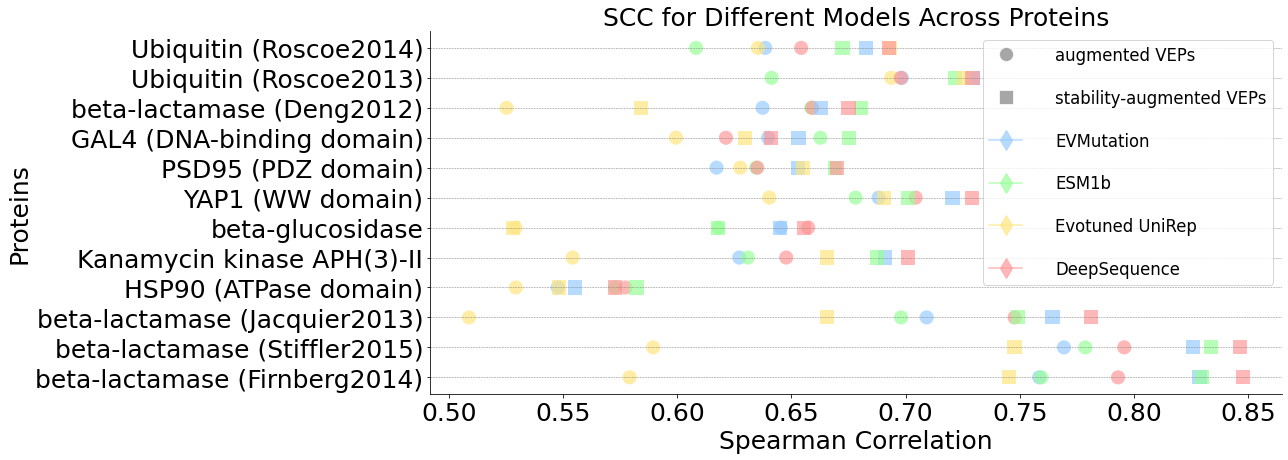

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

files = [
    'BLAT_ECOLX_Ostermeier2014-linear',
    'BLAT_ECOLX_Ranganathan2015-2500',
    'BLAT_ECOLX_Tenaillon2013-singles-MIC_score',
    'HSP82_YEAST_Bolon2016-selection_coefficient',
    'KKA2_KLEPN_Mikkelsen2014-Kan18_avg',
    'BG_STRSQ_Abate2015-enrichment',
    'YAP1_HUMAN_Fields2012-singles-linear',
    'DLG4_RAT_Ranganathan2012-CRIPT',
    'GAL4_YEAST_Shendure2015-SEL_C_40h',
    'BLAT_ECOLX_Palzkill2012-ddG_stat',
    'RL401_YEAST_Bolon2013-selection_coefficient',
    'RL401_YEAST_Bolon2014-react_rel',
]

labels = [
    'beta-lactamase (Firnberg2014)',
    'beta-lactamase (Stiffler2015)',
    'beta-lactamase (Jacquier2013)',
    'HSP90 (ATPase domain)',
    'Kanamycin kinase APH(3)-II',
    'beta-glucosidase',
    'YAP1 (WW domain)',
    'PSD95 (PDZ domain)',
    'GAL4 (DNA-binding domain)',
    'beta-lactamase (Deng2012)',
    'Ubiquitin (Roscoe2013)',
    'Ubiquitin (Roscoe2014)',
]

CORE_PREDICTORS = [
    'ev+onehot', 
    'gesm+onehot', 
    'eunirep_ll+onehot',
    'vae+onehot', 
    'ev+onehot+ddg', 
    'gesm+onehot+ddg', 
    'eunirep_ll+onehot+ddg',
    'vae+onehot+ddg'
]

# 定义颜色列表
color_list = ['#99CCFF', '#99FF99', '#FFE680', '#FF9999']

# 模型与颜色映射（按模型顺序循环使用颜色）
colors = {
    'ev+onehot': color_list[0],
    'gesm+onehot': color_list[1],
    'eunirep_ll+onehot': color_list[2],
    'vae+onehot': color_list[3],
    'ev+onehot+ddg': color_list[0],
    'gesm+onehot+ddg': color_list[1],
    'eunirep_ll+onehot+ddg': color_list[2],
    'vae+onehot+ddg': color_list[3],
}

# 模型与形状映射
shapes = {
    'onehot': 'o',
    'ev+onehot': 'o',  # 没有加 ddg 的用圆形
    'gesm+onehot': 'o',
    'eunirep_ll+onehot': 'o',
    'vae+onehot': 'o',
    'ev+onehot+ddg': 's',  # 加了 ddg 的用方形
    'gesm+onehot+ddg': 's',
    'eunirep_ll+onehot+ddg': 's',
    'vae+onehot+ddg': 's',
}

# 绘图
fig, ax = plt.subplots(figsize=(18, 6.5))

# 遍历 keys
for i, key in enumerate(files):
    df_ = pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results_12/{key}/results.csv')
    
    # 遍历模型
    for model in CORE_PREDICTORS:
        # 获取模型的 spearman 平均值
        mean_scc = df_[df_.predictor == model].spearman.mean()
        
        # 绘制每个模型的点
        plt.scatter(mean_scc, i, color=colors[model], marker=shapes[model], 
                    label=model if i == 0 else "", s=200, alpha=0.7,edgecolors='none')
# 添加虚线
for i in range(len(files)):
    plt.axhline(y=i, color='gray', linestyle='--', linewidth=0.5)
fs = 25
# 设置图形的轴和标题
plt.yticks(ticks=np.arange(len(files)), labels=labels, ha='right', fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlabel('Spearman Correlation', fontsize=fs)
plt.ylabel('Proteins', fontsize=fs)
plt.title('SCC for Different Models Across Proteins', fontsize=fs)

# 添加图例（去除重复图例项）
handles, legend_labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(legend_labels, handles))

augmented_circle = plt.Line2D([0], [0], marker='o', color='w', label='augmented VEPs',
                              markerfacecolor='gray', markersize=s, alpha=0.7)
stability_square = plt.Line2D([0], [0], marker='s', color='w', label='stability-augmented VEPs',
                              markerfacecolor='gray', markersize=s, alpha=0.7)

# 替换模型的图例为对应的x
c_list = []

c_list.append( plt.Line2D([0], [0], marker='d', color=color_list[0], label=f'EVMutation',
                             markersize=s, alpha=0.7))
c_list.append( plt.Line2D([0], [0], marker='d', color=color_list[1], label=f'ESM1b',
                             markersize=s, alpha=0.7))
c_list.append( plt.Line2D([0], [0], marker='d', color=color_list[2], label=f'Evotuned UniRep',
                             markersize=s, alpha=0.7))
c_list.append( plt.Line2D([0], [0], marker='d', color=color_list[3], label=f'DeepSequence',
                             markersize=s, alpha=0.7))


# 添加新的图例到图中
plt.legend(handles=[augmented_circle, stability_square]+c_list, 
           loc='upper right', handletextpad=2, labelspacing=1.5, fontsize=16.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/work/ziang/PSNet/fig4a.pdf', dpi=300)


In [11]:
diff_final = []
for i, key in enumerate(files):
    df_ = pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results_12/{key}/results.csv')
    
    # 遍历模型
    mean_scc_list = {}
    for model in CORE_PREDICTORS:
        # 获取模型的 spearman 平均值
        mean_scc = df_[df_.predictor == model].spearman.mean()
        mean_scc_list[model] = mean_scc
    # diff = mean_scc_list['vae+onehot+ddg'] - mean_scc_list['vae+onehot']
    diff_list = []
    for key in mean_scc_list.keys():
        if key.endswith('ddg'):
            diff = (mean_scc_list[key]-mean_scc_list[key[:-4]])/mean_scc_list[key[:-4]]
            diff_list.append(diff)
    diff_final.append(diff_list)
np.mean(diff_final)

0.070261888959206

In [12]:
diff_final = np.array(diff_final)
diff_final.mean(axis=0),diff_final.mean()

(array([0.05320131, 0.0595181 , 0.12678736, 0.04154078]), 0.070261888959206)

23.25
43.5
55


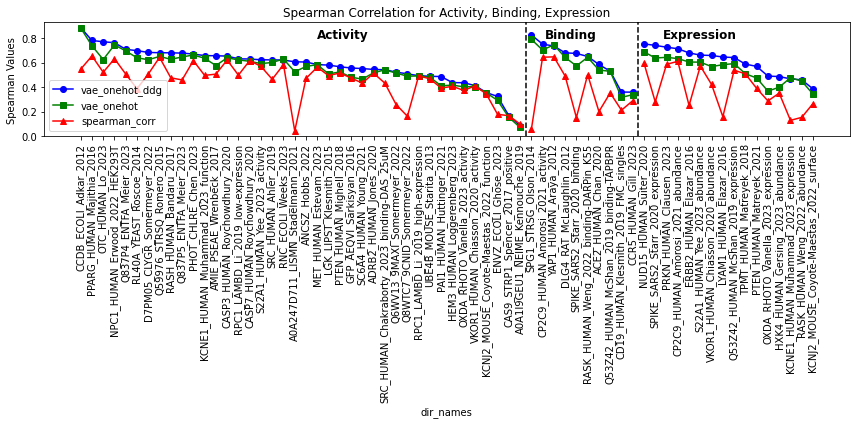

In [15]:
import matplotlib.pyplot as plt
df = pd.DataFrame({
    'dir_names': dir_names,
    'coarse_type': coarse_type,
    'vae_onehot_ddg': vae_onehot_ddg,
    'vae_onehot': vae_onehot,
    'spearman_corr': spearman_corr
})

# Step 1: 过滤掉 vae_onehot_ddg 中的 NaN 值
df = df.dropna(subset=['vae_onehot_ddg'])

# Step 2: 按照 vae_onehot_ddg 从大到小排序
df = df.sort_values(by='vae_onehot_ddg', ascending=False)

# Step 3: 按照 coarse_type 分类
types = ['Activity', 'Binding', 'Expression']

# 创建图形
plt.figure(figsize=(12, 6))

# 记录每个类别的分隔位置
sep_lines = []

# 用不同的颜色绘制每个类别的值
for c_type in types:
    # 当前类型的数据
    df_subset = df[df['coarse_type'] == c_type]
    
    # 绘制 vae_onehot_ddg, vae_onehot, spearman_corr
    plt.plot(df_subset['dir_names'], df_subset['vae_onehot_ddg'], label=f'{c_type} vae_onehot_ddg', marker='o', linestyle='-', color='blue')
    plt.plot(df_subset['dir_names'], df_subset['vae_onehot'], label=f'{c_type} vae_onehot', marker='s', linestyle='-', color='green')
    plt.plot(df_subset['dir_names'], df_subset['spearman_corr'], label=f'{c_type} spearman_corr', marker='^', linestyle='-', color='red')

    # 记录分隔线的位置
    if not df_subset.empty:
        sep_lines.append(df_subset.index[-1] + 0.5)

for i, (sep, label) in enumerate(zip([51.5, 40.5,200], types)):
    # 计算 mid_point 的方式，对于最后一个 type，mid_point 需要特殊处理
    if i < len(sep_lines) - 1:
        mid_point = (sep_lines[i] + (sep_lines[i-1] if i > 0 else 0)) / 2
    if sep<100:
        plt.axvline(x=sep-2+i, color='black', linestyle='--')
    else:
        mid_point = 55
    

    print(mid_point)
    # 在每个分隔区域上方添加文本标注
    plt.text(mid_point, plt.ylim()[1]-0.15, label, ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')


# 设置图表的 x 轴和 y 轴
plt.xticks(rotation=90)
plt.xlabel('dir_names')
plt.ylabel('Spearman Values')
plt.title('Spearman Correlation for Activity, Binding, Expression')
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:3]
labels = [i.split(' ')[-1] for i in labels[:3]]
plt.legend(handles, labels)

# 调整布局和显示图表
plt.tight_layout()
plt.show()

In [3]:

import pandas as pd
import glob
import numpy as np
files = glob.glob('/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/*/')
# key = 'BG_STRSQ_Abate2015-enrichment'
vae_onehot = []
vae_onehot_ddg = []
for key in [ i.split('/')[-2] for i in  files]:
    try:
        df_ = pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/{key}/results.csv')

        # df_ =pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/BLAT_ECOLX_Ranganathan2015-2500/results_BLAT_ECOLX_Ranganathan2015-2500.csv')
        CORE_PREDICTORS = [
            'vae+onehot', 
            'vae+onehot+ddg'
        ]
        for model in CORE_PREDICTORS:
            # print(model, df_[df_.predictor==model].spearman.mean())
            if model == 'vae+onehot':
                vae_onehot.append(df_[df_.predictor==model].spearman.mean())
            else:
                vae_onehot_ddg.append(df_[df_.predictor==model].spearman.mean())
    except:
        vae_onehot.append(np.nan)
        vae_onehot_ddg.append(np.nan)
        print(key)
vae_onehot = np.array(vae_onehot)
vae_onehot_ddg = np.array(vae_onehot_ddg)
((vae_onehot_ddg-vae_onehot)>0).sum()
# analyze results
spearman_corr = []
coarse_type = []
dir_names = [ i.split('/')[-2] for i in  files]
import pandas as pd
df = pd.read_csv('/work/commons/proteingym/DMS_substitutions.csv')
filtered_df = df[df['coarse_selection_type'].isin(['Binding', 'Activity', 'Expression','OrganismalFitness'])]
for dir_name in  dir_names: 


    groundtruth = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/fast_eval/{dir_name}/data.csv'
    deepseq = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/inference/fast_eval/{dir_name}/DeepSequence/pll.csv'

    df = pd.read_csv(groundtruth)
    df_deepseq = pd.read_csv(deepseq)
    from scipy.stats import spearmanr

    spearman_corr.append(-spearmanr(df['log_fitness'],df_deepseq['pll'])[0])
    coarse_type.append(filtered_df[filtered_df.DMS_id==dir_name].reset_index(drop=True).coarse_selection_type[0])

NRAM_I33A0_Jiang_2016
KCNH2_HUMAN_Kozek_2020
POLG_CXB3N_Mattenberger_2021
F7YBW8_MESOW_Aakre_2015
NPC1_HUMAN_Erwood_2022_RPE1
BRCA2_HUMAN_Erwood_2022_HEK293T
AICDA_HUMAN_Gajula_2014_3cycles
RAF1_HUMAN_Zinkus-Boltz_2019
GCN4_YEAST_Staller_2018
SPG1_STRSG_Wu_2016
F7YBW7_MESOW_Ding_2023
A0A140D2T1_ZIKV_Sourisseau_2019
POLG_HCVJF_Qi_2014
OPSD_HUMAN_Wan_2019
SCN5A_HUMAN_Glazer_2019
GLPA_HUMAN_Elazar_2016
HIS7_YEAST_Pokusaeva_2019
B2L11_HUMAN_Dutta_2010_binding-Mcl-1


['Stability-Augmented DeepSequence', 'Augmented DeepSequence']


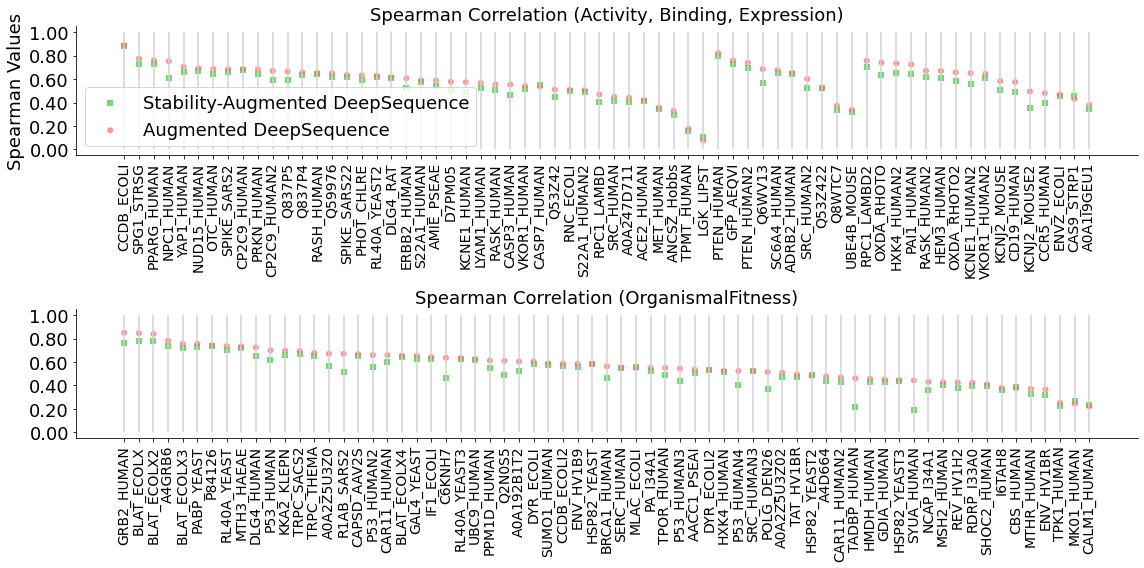

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 假设数据 df 已经定义
df = pd.DataFrame({
    'dir_names': dir_names,
    'coarse_type': coarse_type,
    'vae_onehot_ddg': vae_onehot_ddg,
    'vae_onehot': vae_onehot,
    'spearman_corr': spearman_corr
})

# Step 1: 过滤掉 vae_onehot_ddg 中的 NaN 值
df = df.dropna(subset=['vae_onehot_ddg'])

# Step 2: 按照 vae_onehot_ddg 从大到小排序
df = df.sort_values(by='vae_onehot_ddg', ascending=False)

# Step 3: 按照 coarse_type 分类
types_1 = ['Activity', 'Binding','Expression', ]  # 第一个子图中的类型
types_2 = ['OrganismalFitness']  # 第二个子图中的类型

# 对 dir_names 进行处理，分离前缀并添加编号
# dir_name_prefixes = [x.split('_')[0] for x in df['dir_names']]
name_counter = {}

# 遍历所有前缀，检查是否重复，重复则添加编号
processed_dir_names = []
for org_name in df['dir_names']:
    name = org_name.split('_')[0]
    if len(name)<=5:
        name = ('_').join(org_name.split('_')[:2])
    if name not in name_counter:
        name_counter[name] = 1
    else:
        name_counter[name] += 1
    if name_counter[name] > 1:
        processed_dir_names.append(f'{name}{name_counter[name]}')
    else:
        processed_dir_names.append(name)

# 更新处理后的 dir_names 列
df['processed_dir_names'] = processed_dir_names
processed_dir_names_dict = dict(zip(df['dir_names'],df['processed_dir_names']))
# 创建图形和两个子图对象
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
alpha = 0.7
# 绘制第一个子图 (Activity, Expression, OrganismalFitness)
for c_type in types_1:
    df_subset = df[df['coarse_type'] == c_type]
    ax1.scatter(df_subset['processed_dir_names'], df_subset['vae_onehot'], label=f'{c_type} vae_onehot', marker='s', color='#33CC33',alpha=alpha,edgecolors='none')
    # 绘制 vae_onehot_ddg 的点
    ax1.scatter(df_subset['processed_dir_names'], df_subset['vae_onehot_ddg'], label=f'{c_type} vae_onehot_ddg', marker='o', color='#FF6666',alpha=alpha,edgecolors='none')
    
    # 绘制 vae_onehot 的点
    

# 为每个点绘制沿 y 轴的浅灰色实线
ax1.vlines(range(len(df[df['coarse_type'].isin(types_1)])), ymin=0, ymax=1, colors='#D3D3D3', linestyles='solid')

# 设置第一个子图的 x 轴和 y 轴
ax1.set_xticks(range(len(df[df['coarse_type'].isin(types_1)])))
# df in types_1
ax1.set_xticklabels(df[df['coarse_type'].isin(types_1)]['processed_dir_names'], rotation=90, fontsize=14)
ax1.set_yticks(np.arange(0, 1.1, 0.2))
ax1.set_yticklabels([f'{i:.2f}' for i in np.arange(0, 1.1, 0.2)], fontsize=18)
ax1.set_ylabel('Spearman Values', fontsize=18)
ax1.set_title('Spearman Correlation (Activity, Binding, Expression)', fontsize=18)

# 绘制第二个子图 (Binding)
for c_type in types_2:
    # 当前类型的数据
    df_subset = df[df['coarse_type'] == c_type]
    ax2.scatter(df_subset['processed_dir_names'], df_subset['vae_onehot'], label=f'{c_type} vae_onehot', marker='s', color='#33CC33',alpha=alpha,edgecolors='none')
    # 绘制 vae_onehot_ddg 的点
    ax2.scatter(df_subset['processed_dir_names'], df_subset['vae_onehot_ddg'], label=f'{c_type} vae_onehot_ddg', marker='o', color='#FF6666',alpha=alpha,edgecolors='none')
    
    # 绘制 vae_onehot 的点
    

# 为每个点绘制沿 y 轴的浅灰色实线
ax2.vlines(range(len(df[df['coarse_type'].isin(types_2)])), ymin=0, ymax=1, colors='#D3D3D3', linestyles='solid')

# 设置第二个子图的 x 轴和 y 轴
ax2.set_xticks(range(len(df[df['coarse_type'].isin(types_2)])))
# df in types_1
ax2.set_xticklabels(df[df['coarse_type'].isin(types_2)]['processed_dir_names'], rotation=90, fontsize=14)
ax2.set_yticks(np.arange(0, 1.1, 0.2))
ax2.set_yticklabels([f'{i:.2f}' for i in np.arange(0, 1.1, 0.2)], fontsize=18)
ax2.set_title('Spearman Correlation (OrganismalFitness)', fontsize=18)

# 隐藏顶部和右侧的边框
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# 创建图例
handles, labels = ax1.get_legend_handles_labels()
handles = handles[:2]
labels = ['Stability-Augmented DeepSequence','Augmented DeepSequence']
print(labels)
ax1.legend(handles, labels, fontsize=18, loc='lower left')

# 调整布局和显示图表
plt.tight_layout()
plt.savefig('/work/ziang/PSNet/fig4b.pdf', dpi=300)
plt.show()


In [24]:
# ((df['vae_onehot_ddg']-df['vae_onehot'])>0).sum(),len(df),((df['vae_onehot_ddg']-df['vae_onehot'])/df['vae_onehot']).mean()
# cal them type by type
for c_type in types_1+types_2:
    df_subset = df[df['coarse_type'] == c_type]
    print(c_type,((df_subset['vae_onehot_ddg']-df_subset['vae_onehot'])>0).sum(),len(df_subset),((df_subset['vae_onehot_ddg']-df_subset['vae_onehot'])/df_subset['vae_onehot']).mean())

Activity 38 40 0.06460876881803715
Expression 15 16 0.13020857955182508
Binding 9 10 0.07287138680687705
OrganismalFitness 61 67 0.11845017538287013


In [9]:
df

,dir_names,coarse_type,vae_onehot_ddg,vae_onehot,spearman_corr,processed_dir_names
119,CCDB_ECOLI_Adkar_2012,Activity,0.888970,0.882410,0.546883,CCDB_ECOLI
149,GRB2_HUMAN_Faure_2021,OrganismalFitness,0.850860,0.764830,0.559495,GRB2_HUMAN
133,BLAT_ECOLX_Firnberg_2014,OrganismalFitness,0.847220,0.783290,0.746971,BLAT_ECOLX
125,BLAT_ECOLX_Stiffler_2015,OrganismalFitness,0.839740,0.780030,0.743181,BLAT_ECOLX2
80,SPG1_STRSG_Olson_2014,Binding,0.822910,0.796980,0.053686,SPG1_STRSG
...,...,...,...,...,...,...
42,TPK1_HUMAN_Weile_2017,OrganismalFitness,0.252855,0.225675,0.227638,TPK1_HUMAN
86,MK01_HUMAN_Brenan_2016,OrganismalFitness,0.244530,0.270975,0.241410,MK01_HUMAN
132,CALM1_HUMAN_Weile_2017,OrganismalFitness,0.220905,0.234030,0.233168,CALM1_HUMAN
141,CAS9_STRP1_Spencer_2017_positive,Activity,0.175995,0.152620,0.166268,CAS9_STRP1


In [33]:
# 导入必要的模块
from itertools import zip_longest

# 定义一个函数来转义LaTeX中的特殊字符
def escape_latex(text):
    replacements = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\textasciicircum{}',
        '\\': r'\textbackslash{}',
    }
    for original, replacement in replacements.items():
        text = text.replace(original, replacement)
    return text

# 选择12个示例条目
data = {
    'CCDB_ECOLI_Adkar_2012': 'CCDB_ECOLI',
    'GRB2_HUMAN_Faure_2021': 'GRB2_HUMAN',
    'BLAT_ECOLX_Firnberg_2014': 'BLAT_ECOLX',
    'BLAT_ECOLX_Stiffler_2015': 'BLAT_ECOLX2',
    'SPG1_STRSG_Olson_2014': 'SPG1_STRSG',
    'A4GRB6_PSEAI_Chen_2020': 'A4GRB6',
    'PPARG_HUMAN_Majithia_2016': 'PPARG_HUMAN',
    'NPC1_HUMAN_Erwood_2022_HEK293T': 'NPC1_HUMAN',
    'YAP1_HUMAN_Araya_2012': 'YAP1_HUMAN',
    'NUD15_HUMAN_Suiter_2020': 'NUD15_HUMAN',
    'BLAT_ECOLX_Jacquier_2013': 'BLAT_ECOLX3',
    'PABP_YEAST_Melamed_2013': 'PABP_YEAST'
}

# 步骤1：按简写排序
sorted_items = sorted(data.items(), key=lambda item: item[1])

# 步骤2：将排序后的条目每两对分为一行
# 生成一个列表，只包含（简写, 全称）的元组
sorted_pairs = [(escape_latex(abbr), escape_latex(full)) for full, abbr in sorted_items]

# 使用zip_longest每两对分为一行
pairs = list(zip_longest(sorted_pairs[::2], sorted_pairs[1::2]))

# 步骤3：生成LaTeX表格行
latex_rows = []
for pair in pairs:
    # 每个pair包含两个元组：((abbr1, full1), (abbr2, full2))
    if pair[1]:
        abbr1, full1 = pair[0]
        abbr2, full2 = pair[1]
        row = f"{abbr1} & {full1} & {abbr2} & {full2} \\\\"
    else:
        # 如果只有一个配对（奇数条目），则后两列留空
        abbr1, full1 = pair[0]
        row = f"{abbr1} & {full1} &  &  \\\\"
    latex_rows.append(row)

# 步骤4：构建完整的LaTeX表格，包含竖线
latex_table = r"""
\begin{table}[ht]
\centering
\begin{tabular}{l|l||l|l}
\hline
\textbf{简写 1} & \textbf{全称 1} & \textbf{简写 2} & \textbf{全称 2} \\
\hline
"""

# 添加所有行
for row in latex_rows:
    latex_table += row + "\n"

# 关闭表格
latex_table += r"""
\hline
\end{tabular}
\caption{简写与全称对应关系示例}
\label{tab:abbrev_fullnames_example}
\end{table}
"""

# 打印LaTeX表格代码
print(latex_table)



\begin{table}[ht]
\centering
\begin{tabular}{l|l||l|l}
\hline
\textbf{简写 1} & \textbf{全称 1} & \textbf{简写 2} & \textbf{全称 2} \\
\hline
A4GRB6 & A4GRB6\textbackslash{}_PSEAI\textbackslash{}_Chen\textbackslash{}_2020 & BLAT\textbackslash{}_ECOLX & BLAT\textbackslash{}_ECOLX\textbackslash{}_Firnberg\textbackslash{}_2014 \\
BLAT\textbackslash{}_ECOLX2 & BLAT\textbackslash{}_ECOLX\textbackslash{}_Stiffler\textbackslash{}_2015 & BLAT\textbackslash{}_ECOLX3 & BLAT\textbackslash{}_ECOLX\textbackslash{}_Jacquier\textbackslash{}_2013 \\
CCDB\textbackslash{}_ECOLI & CCDB\textbackslash{}_ECOLI\textbackslash{}_Adkar\textbackslash{}_2012 & GRB2\textbackslash{}_HUMAN & GRB2\textbackslash{}_HUMAN\textbackslash{}_Faure\textbackslash{}_2021 \\
NPC1\textbackslash{}_HUMAN & NPC1\textbackslash{}_HUMAN\textbackslash{}_Erwood\textbackslash{}_2022\textbackslash{}_HEK293T & NUD15\textbackslash{}_HUMAN & NUD15\textbackslash{}_HUMAN\textbackslash{}_Suiter\textbackslash{}_2020 \\
PABP\textbackslash{}_YEAST & PABP